In [1]:
import pandas as pd
import glob
import re
from pandas.tseries.offsets import MonthEnd

# 1. Load and concatenate all revenue CSVs
file_paths = glob.glob('data/revenue/revenue_*.csv')
dfs = []
for fp in file_paths:
    df = pd.read_csv(
        fp,
        parse_dates=['운행시작일','운행종료일'],
        dtype={'총청구요금': str}
    )
    df.rename(columns={
        '운행시작일': 'rental_start',
        '운행종료일': 'rental_end',
        '총청구요금': 'total_revenue',
        '차량번호':  'vehicle_id'
    }, inplace=True)
    # remove commas and convert to float
    df['total_revenue'] = df['total_revenue'].str.replace(',','').astype(float)
    dfs.append(df)

all_data = pd.concat(dfs, ignore_index=True)
all_data = all_data.dropna(subset=['rental_start','rental_end'])

# 2. Determine analysis window from filenames
months = sorted(re.search(r'revenue_(\d{6})\.csv', fp).group(1) for fp in file_paths)
start_date = pd.to_datetime(f"{months[0]}01") + pd.Timedelta(days=5)
end_date   = pd.to_datetime(f"{months[-1]}01") + MonthEnd(0)

# 3. Compute daily revenue share
all_data['rental_days']   = (all_data['rental_end'] - all_data['rental_start']).dt.days + 1
all_data['daily_revenue'] = all_data['total_revenue'] / all_data['rental_days']

# 4. Spread each rental across its date range
daily_data = (
    all_data
    .assign(date=lambda d: d.apply(
        lambda r: pd.date_range(r['rental_start'],r['rental_end']), axis=1
    ))
    .explode('date')
)

# 5. Filter to analysis window
daily_data = daily_data[
    (daily_data['date'] >= start_date) &
    (daily_data['date'] <= end_date)
]

# 6. Aggregate into daily_summary
daily_summary = (
    daily_data
    .groupby('date')
    .agg(
        total_revenue      = ('daily_revenue','sum'),
        vehicle_count      = ('vehicle_id','nunique')
    )
    .reset_index()
    .sort_values('date')
)
daily_summary['revenue_per_vehicle'] = (
    daily_summary['total_revenue'] / daily_summary['vehicle_count']
)

# Now daily_summary is ready for your MLP inputs
print(daily_summary.head())


C:\Users\PPC-NB-\AppData\Local\Temp\ipykernel_8340\2337481388.py:10: DtypeWarning: Columns (10,30,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\PPC-NB-\AppData\Local\Temp\ipykernel_8340\2337481388.py:10: DtypeWarning: Columns (10,21,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\PPC-NB-\AppData\Local\Temp\ipykernel_8340\2337481388.py:10: DtypeWarning: Columns (10,21,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\PPC-NB-\AppData\Local\Temp\ipykernel_8340\2337481388.py:10: DtypeWarning: Columns (10,21,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\PPC-NB-\AppData\Local\Temp\ipykernel_8340\2337481388.py:10: DtypeWarning: Columns (10,21,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
C:\Users\PPC-N

        date  total_revenue  vehicle_count  revenue_per_vehicle
0 2023-01-06   4.384192e+07           1079         40631.990778
1 2023-01-07   6.870620e+07           1260         54528.734034
2 2023-01-08   6.838400e+07           1234         55416.535427
3 2023-01-09   4.091286e+07           1033         39605.868377
4 2023-01-10   4.062744e+07           1016         39987.637697


In [3]:
import pandas as pd
import numpy as np

# 1) Load your daily_summary (if you saved to CSV; otherwise assume it's in memory)
# daily_summary = pd.read_csv('daily_summary.csv', parse_dates=['date'])

# 2) Load weather data
weather = pd.read_csv(
    'data/weather/weather_2023.csv',
    parse_dates=['date'],
    dtype={'T': float, 'RH': float, 'P': float, 'W': float, 'S': float}
)[['date','T','RH','P','W','S']]

# 3) Load holiday calendar
df_holidays = pd.read_feather('data/2023~2025년_휴일_데이터_38rows.feather')
df_holidays = df_holidays.rename(columns={'일자':'date','휴일명':'holiday_name'})
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

# 4) Build a calendar to compute offday_run
cal = pd.DataFrame({
    'date': pd.date_range(
        start=daily_summary['date'].min(),
        end=daily_summary['date'].max()
    )
})
cal['weekday']    = cal['date'].dt.weekday
cal['is_weekend'] = cal['weekday'] >= 5
cal['is_holiday'] = cal['date'].isin(df_holidays['date'])
cal['is_offday']  = cal['is_weekend'] | cal['is_holiday']
cal['block_id']   = (cal['is_offday'] != cal['is_offday'].shift(1)).cumsum()
cal['offday_run'] = cal.groupby('block_id')['is_offday'].transform('sum')
cal['offday_run'] = cal['offday_run'].where(cal['is_offday'], 0)

# 5) Merge into one DataFrame
df_features = (
    daily_summary
    .merge(weather, on='date', how='left')
    .merge(cal[['date','weekday','is_holiday','is_offday','offday_run']], on='date', how='left')
)

# 6) Quick check
df_features.head()


,date,total_revenue,vehicle_count,revenue_per_vehicle,T,RH,P,W,S,weekday,is_holiday,is_offday,offday_run
0,2023-01-06,4.384192e+07,1079,40631.990778,0.6,71.9,3.9,2.2,9.7,4,False,False,0
1,2023-01-07,6.870620e+07,1260,54528.734034,1.5,80.9,0.1,2.2,9.7,5,False,True,2
2,2023-01-08,6.838400e+07,1234,55416.535427,1.3,69.3,0.0,1.7,9.7,6,False,True,2
3,2023-01-09,4.091286e+07,1033,39605.868377,3.1,60.1,0.0,2.3,9.7,0,False,False,0
4,2023-01-10,4.062744e+07,1016,39987.637697,1.6,59.9,0.0,1.5,9.8,1,False,False,0


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

# 1) Prepare X, y
features = ['T', 'RH', 'P', 'W', 'S', 'weekday', 'is_holiday', 'is_offday', 'offday_run']
X = df_features[features]
y = df_features['revenue_per_vehicle']

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) Preprocessing pipeline
numeric_feats = ['T', 'RH', 'P', 'W', 'S', 'offday_run']
cat_feats     = ['weekday', 'is_holiday', 'is_offday']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(),          numeric_feats),
    ('cat', OneHotEncoder(drop='first'), cat_feats)
])

# 4) MLP pipeline
pipeline = Pipeline([
    ('pre', preprocessor),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        alpha=1e-3,
        max_iter=10000,
        early_stopping=False,
        random_state=42
    ))
])

# 5) Fit
pipeline.fit(X_train, y_train)

# 6) Evaluate
y_pred_tr = pipeline.predict(X_train)
y_pred_te = pipeline.predict(X_test)

print(f"Train R²: {r2_score(y_train, y_pred_tr):.3f}")
print(f" Test R²: {r2_score(y_test,  y_pred_te):.3f}")
mse = mean_squared_error(y_test, y_pred_te)
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse:,.2f}")


Train R²: 0.902
 Test R²: 0.783
Test RMSE: 4,550.13


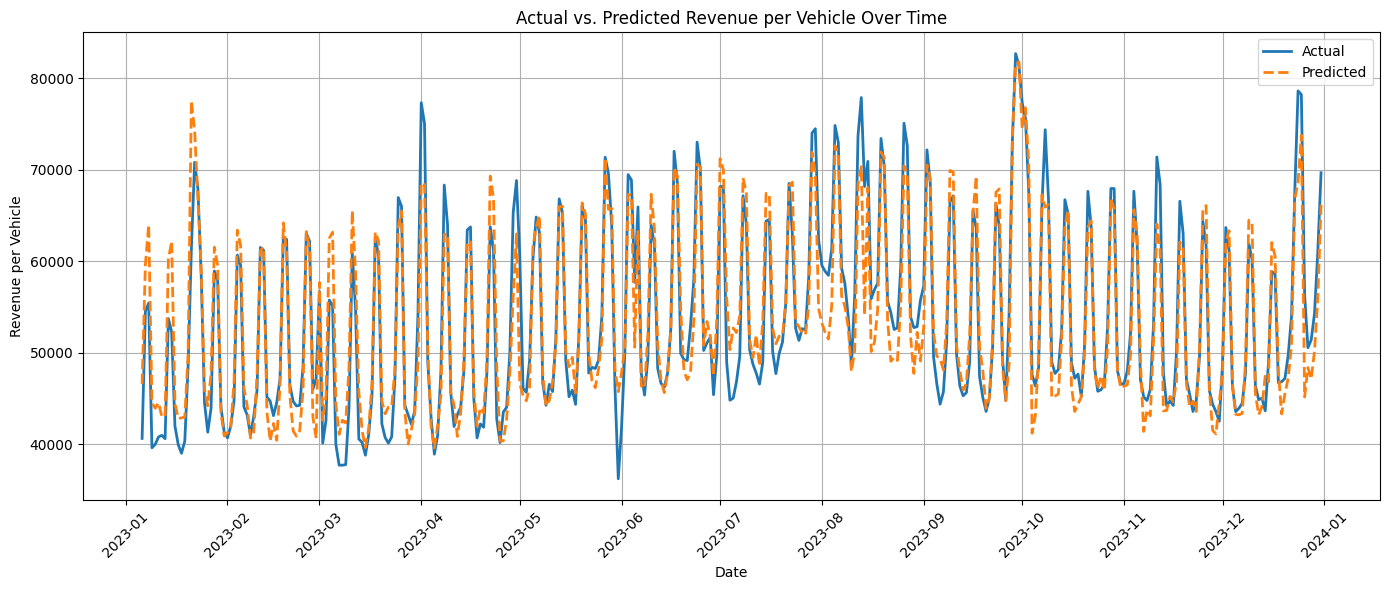

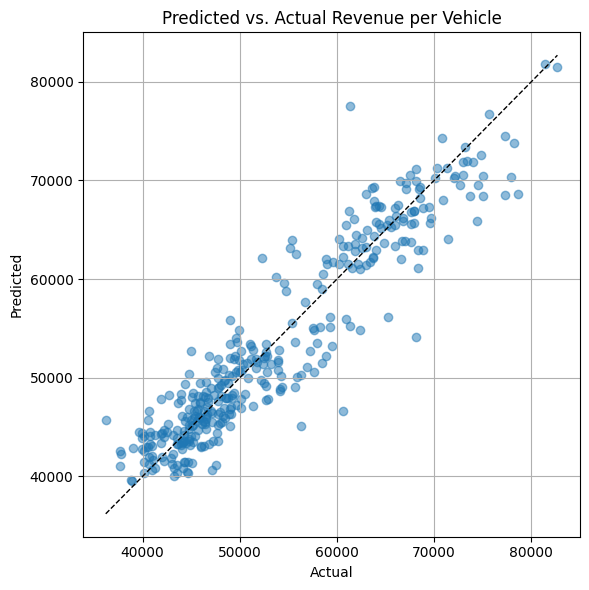

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Prepare plotting DataFrame
df_plot = df_features.copy()
df_plot['predicted'] = pipeline.predict(df_plot[features])
df_plot['date'] = pd.to_datetime(df_plot['date'])

# 2) Time‐series plot of actual vs. predicted
plt.figure(figsize=(14,6))
plt.plot(df_plot['date'], df_plot['revenue_per_vehicle'], label='Actual', lw=2)
plt.plot(df_plot['date'], df_plot['predicted'],       label='Predicted', ls='--', lw=2)
plt.title('Actual vs. Predicted Revenue per Vehicle Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue per Vehicle')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3) Scatter plot: Predicted vs. Actual
plt.figure(figsize=(6,6))
plt.scatter(df_plot['revenue_per_vehicle'], df_plot['predicted'], alpha=0.5)
mn = min(df_plot['revenue_per_vehicle'].min(), df_plot['predicted'].min())
mx = max(df_plot['revenue_per_vehicle'].max(), df_plot['predicted'].max())
plt.plot([mn, mx],[mn, mx],'k--', lw=1)
plt.title('Predicted vs. Actual Revenue per Vehicle')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import mean_squared_error, r2_score

# --- 1) Feature engineering ---
# assume df_features exists with columns:
#  date, T, RH, P, W, S, offday_run, weekday_* , is_holiday_* , is_offday_*
# add time‐index feature
df_features['t'] = (df_features['date'] - df_features['date'].min()).dt.days

# one‐hot encode if you haven't yet:
df_ml = pd.get_dummies(
    df_features,
    columns=['weekday','is_holiday','is_offday'],
    drop_first=True
)

# define feature lists
numeric_feats = ['T','RH','P','W','S','offday_run','t']
cat_feats = [c for c in df_ml.columns 
             if c.startswith('weekday_') 
             or c.startswith('is_holiday_') 
             or c.startswith('is_offday_')]
features = numeric_feats + cat_feats

# extract X, y
X_raw = df_ml[features].values.astype(np.float32)
y_raw = df_ml['revenue_per_vehicle'].values.astype(np.float32).reshape(-1,1)

# standardize X numerics
scaler_X = StandardScaler()
X = X_raw.copy()
X[:, :len(numeric_feats)] = scaler_X.fit_transform(X[:, :len(numeric_feats)])

# normalize y
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y_raw).flatten()

# --- 2) Dataset class ---
class RevenueDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).unsqueeze(1)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = RevenueDataset(X, y)

# --- 3) MLP model class ---
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

# --- 4) K-Fold training & evaluation on CPU ---
device = torch.device('cpu')
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list, r2_list = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    # split out a validation set
    train_idx, val_idx = train_test_split(train_idx, test_size=0.1, random_state=42)
    loaders = {
        'train': DataLoader(Subset(dataset, train_idx), batch_size=64, shuffle=True),
        'val':   DataLoader(Subset(dataset, val_idx),   batch_size=64, shuffle=False),
        'test':  DataLoader(Subset(dataset, test_idx),  batch_size=64, shuffle=False)
    }

    model = MLPRegressor(input_dim=X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    best_val, patience, cnt = np.inf, 20, 0
    best_state = None

    # training loop with early stopping
    for epoch in range(200):
        model.train()
        for xb, yb in loaders['train']:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in loaders['val']:
                xb, yb = xb.to(device), yb.to(device)
                val_losses.append(criterion(model(xb), yb).item())
        val_loss = np.mean(val_losses)

        if val_loss < best_val:
            best_val, best_state, cnt = val_loss, model.state_dict(), 0
        else:
            cnt += 1
            if cnt >= patience:
                break

    # load best model and evaluate on test set
    model.load_state_dict(best_state)
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loaders['test']:
            xb = xb.to(device)
            preds.append(model(xb).cpu().numpy())
            trues.append(yb.numpy())
    preds = np.vstack(preds)
    trues = np.vstack(trues)

    rmse = np.sqrt(mean_squared_error(trues, preds))
    r2   = r2_score(trues, preds)
    print(f"Fold {fold+1} — RMSE: {rmse:.2f}, R²: {r2:.3f}")
    rmse_list.append(rmse)
    r2_list.append(r2)

print(f"\nAverage RMSE: {np.mean(rmse_list):.2f}, Average R²: {np.mean(r2_list):.3f}")


Fold 1 — RMSE: 0.38, R²: 0.840
Fold 2 — RMSE: 0.37, R²: 0.867
Fold 3 — RMSE: 0.38, R²: 0.860
Fold 4 — RMSE: 0.35, R²: 0.897
Fold 5 — RMSE: 0.40, R²: 0.816

Average RMSE: 0.37, Average R²: 0.856


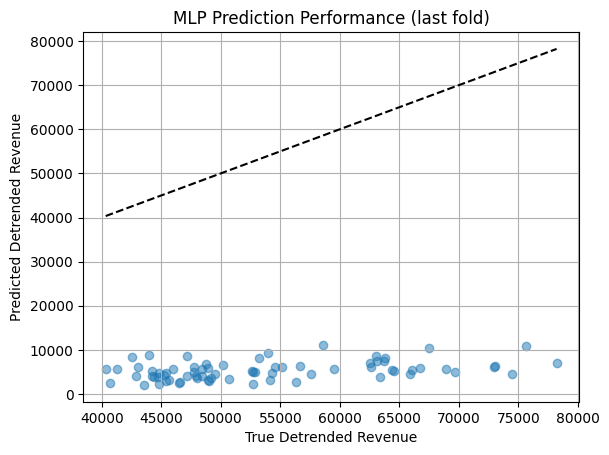

In [14]:
import matplotlib.pyplot as plt

plt.scatter(trues, preds, alpha=0.5)
mn, mx = trues.min(), trues.max()
plt.plot([mn, mx], [mn, mx], 'k--')
plt.xlabel('True Detrended Revenue')
plt.ylabel('Predicted Detrended Revenue')
plt.title('MLP Prediction Performance (last fold)')
plt.grid(True)
plt.show()


In [2]:
import os
import glob
import re
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
from prophet.serialize import model_from_json
import weatherReturn
import day_factor_module

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# 0) FORCE CPU‐ONLY
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 1) LOAD & PREPARE REVENUE DATA
file_paths = glob.glob('data/revenue/revenue_*.csv')
dfs = []
for fp in file_paths:
    df = pd.read_csv(fp,
                     parse_dates=['운행시작일','운행종료일'],
                     dtype={'총청구요금':str})
    df.rename(columns={
        '운행시작일':'rental_start',
        '운행종료일':'rental_end',
        '총청구요금':'total_revenue',
        '차량번호':'vehicle_id'
    }, inplace=True)
    df['total_revenue'] = df['total_revenue'].str.replace(',','').astype(float)
    dfs.append(df)
all_data = pd.concat(dfs, ignore_index=True).dropna(subset=['rental_start','rental_end'])

months = sorted(re.search(r'revenue_(\d{6})\.csv', fp).group(1)
                for fp in file_paths)
start_date = pd.to_datetime(f"{months[0]}01") + pd.Timedelta(days=5)
end_date   = pd.to_datetime(f"{months[-1]}01") + MonthEnd(0)

all_data['rental_days'] = (all_data['rental_end'] - all_data['rental_start']).dt.days + 1
all_data['daily_rev']   = all_data['total_revenue'] / all_data['rental_days']

daily = (all_data
         .assign(date=lambda d: d.apply(
             lambda r: pd.date_range(r['rental_start'],r['rental_end']), axis=1))
         .explode('date'))
daily = daily[(daily['date']>=start_date)&(daily['date']<=end_date)]

daily_summary = (daily.groupby('date')
                 .agg(total_rev=('daily_rev','sum'),
                      vehicle_count=('vehicle_id','nunique'))
                 .reset_index()
                 .sort_values('date'))
daily_summary['revenue_per_vehicle'] = (
    daily_summary['total_rev']/daily_summary['vehicle_count']
)

# 2) CALENDAR FEATURES
df_hol = pd.read_feather('data/2023~2025년_휴일_데이터_38rows.feather')
df_hol.rename(columns={'일자':'date','휴일명':'holiday_name'}, inplace=True)
df_hol['date'] = pd.to_datetime(df_hol['date'])

cal = pd.DataFrame({'date': pd.date_range(start_date,end_date)})
cal['weekday']    = cal['date'].dt.weekday
cal['is_holiday'] = cal['date'].isin(df_hol['date'])
cal['is_offday']  = (cal['weekday']>=5) | cal['is_holiday']
cal['block_id']   = (cal['is_offday']!=cal['is_offday'].shift(1)).cumsum()
cal['offday_run'] = cal.groupby('block_id')['is_offday'].transform('sum')
cal['offday_run'] = cal['offday_run'].where(cal['is_offday'],0)

df_features = daily_summary.merge(cal, on='date', how='left')

# 3) RAW WEATHER + DAY + ANNUAL FACTORS
weather = pd.read_csv('data/weather/weather_2023.csv', parse_dates=['date'])
weather = weather[['date','T','RH','P','W','S']]

df_features = df_features.merge(weather, on='date', how='left')
df_features['weather_score'] = df_features['date'] \
    .dt.strftime('%Y%m%d') \
    .apply(lambda d: weatherReturn.get_weather_score_from_csv(d))
df_features['day_factor'] = df_features['date'] \
    .apply(lambda d: day_factor_module.get_day_factor(d))

with open('data/prophet_model.json','r') as f:
    m = model_from_json(f.read())
df_ann = pd.DataFrame({'ds': df_features['date']})
seas = m.predict_seasonal_components(df_ann)
df_features['annual_factor'] = seas['yearly'] + 1

# 4) TIME & CYCLICAL FEATURES
df_features['t'] = (df_features['date'] - df_features['date'].min()).dt.days
doy = df_features['date'].dt.dayofyear
df_features['sin_doy'] = np.sin(2*np.pi * doy / 365)
df_features['cos_doy'] = np.cos(2*np.pi * doy / 365)

# --- NEW: 2) BINARY WEATHER FLAGS & INTERACTIONS
df_features['rain_flag']    = (df_features['P'] > 0).astype(int)
df_features['windy_flag']   = (df_features['W'] > df_features['W'].quantile(0.75)).astype(int)
df_features['rain_weekend'] = df_features['rain_flag'] * df_features['is_offday']
df_features['hot_weekday']  = ((df_features['T'] > 30) & (df_features['weekday'] < 5)).astype(int)

# --- NEW: 3) MONTHLY & QUARTER CYCLE
df_features['month']     = df_features['date'].dt.month
df_features['sin_month'] = np.sin(2*np.pi*(df_features['month']-1)/12)
df_features['cos_month'] = np.cos(2*np.pi*(df_features['month']-1)/12)
df_features['quarter']   = df_features['date'].dt.quarter
df_features = pd.get_dummies(df_features, columns=['quarter'], prefix='q', drop_first=True)

# --- NEW: 4) HOLIDAY TYPE & PROXIMITY
df_features = df_features.merge(df_hol[['date','holiday_name']], on='date', how='left')
top_hols = ['설날','추석','광복절','신정']
df_features['holiday_type'] = df_features['holiday_name'].where(
    df_features['holiday_name'].isin(top_hols), 'other'
)
df_features = pd.get_dummies(df_features, columns=['holiday_type'], drop_first=True)
holidays = sorted(df_hol['date'])
df_features['days_to_hol'] = df_features['date'].apply(
    lambda d: min(abs((d-h).days) for h in holidays)
)

# 4.5) LAG & ROLLING STATS OF THE TARGET
# (fill forward/backward so you don’t lose rows at the top)
df_features['rev_lag1'] = df_features['revenue_per_vehicle'].shift(1).fillna(method='bfill')
df_features['rev_lag7'] = df_features['revenue_per_vehicle'].shift(7).fillna(method='bfill')

# 7‐day rolling mean and std (min_periods=1 so we get a value even early on)
df_features['rev_ma7']  = df_features['revenue_per_vehicle']\
                              .rolling(7, min_periods=1).mean()
df_features['rev_std7'] = df_features['revenue_per_vehicle']\
                              .rolling(7, min_periods=1).std().fillna(0)


# 5) ONE-HOT ENCODE REMAINING
df_ml = pd.get_dummies(
    df_features,
    columns=['weekday','is_holiday','is_offday'],
    prefix=['wd','hol','off'],
    drop_first=True
)

# 6) BUILD X, y (LOG TARGET)
numeric_feats = [
    'T','RH','P','W','S','offday_run','t',
    'weather_score',#'annual_factor',
    'sin_doy','cos_doy',
    'rain_flag','windy_flag','rain_weekend','hot_weekday',
    'sin_month','cos_month','days_to_hol',
    'rev_lag1','rev_lag7','rev_ma7','rev_std7'
]
cat_feats = [c for c in df_ml.columns if
             c.startswith(('wd_','hol_','off_','q_','holiday_type_'))]
features = numeric_feats + cat_feats

X_raw = df_ml[features].values.astype(np.float32)
y_raw = np.log(df_ml['revenue_per_vehicle'].values.astype(np.float32)).reshape(-1,1)

scaler_X = StandardScaler()
X = scaler_X.fit_transform(X_raw)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y_raw).flatten()

# 7) DATASET & MODEL
class RevenueDataset(Dataset):
    def __init__(self,X,y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).unsqueeze(1)
    def __len__(self): return len(self.y)
    def __getitem__(self,idx): return self.X[idx], self.y[idx]

dataset = RevenueDataset(X, y)


d:\Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Using device: cuda


C:\Users\User\AppData\Local\Temp\ipykernel_3336\3808248510.py:32: DtypeWarning: Columns (10,30,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp,
C:\Users\User\AppData\Local\Temp\ipykernel_3336\3808248510.py:32: DtypeWarning: Columns (10,21,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp,
C:\Users\User\AppData\Local\Temp\ipykernel_3336\3808248510.py:32: DtypeWarning: Columns (10,21,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp,
C:\Users\User\AppData\Local\Temp\ipykernel_3336\3808248510.py:32: DtypeWarning: Columns (10,21,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp,
C:\Users\User\AppData\Local\Temp\ipykernel_3336\3808248510.py:32: DtypeWarning: Columns (10,21,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp,
C:\Users\User\

In [ ]:
from tqdm.auto import tqdm
# 8) K-FOLD TRAINING w/ LR SCHEDULER & EARLY-STOP

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 1) Define your ComplexMLP (unchanged)
class ComplexMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
        )
        self.block2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
        )
        self.block3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
        )
        self.block4 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
        )
        self.head = nn.Linear(32, 1)
        self.residual_proj = nn.Linear(256, 64)

    def forward(self, x):
        x = self.block1(x)
        x2 = self.block2(x)
        res = self.residual_proj(x)
        x3 = self.block3(x2)
        x3 = x3 + res
        x4 = self.block4(x3)
        return self.head(x4)

# 2) K-FOLD TRAINING w/ GPU support

import time
start_check = time.time()

kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_list, r2_list = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset), start=1):
    # split into train/val
    train_idx, val_idx = train_test_split(train_idx, test_size=0.1, random_state=42)
    loaders = {
        'train': DataLoader(Subset(dataset, train_idx), batch_size=64, shuffle=True,
                             num_workers=4, pin_memory=torch.cuda.is_available(), persistent_workers=True),
        'val':   DataLoader(Subset(dataset, val_idx),   batch_size=64, shuffle=False,
                             num_workers=4, pin_memory=torch.cuda.is_available(), persistent_workers=True),
        'test':  DataLoader(Subset(dataset, test_idx),  batch_size=64, shuffle=False,
                             pin_memory=True if device.type=='cuda' else False)
    }

    model = ComplexMLP(X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=20)
    loss_fn = nn.MSELoss()

    best_val, cnt, patience, best_state = np.inf, 0, 20, None

    for epoch in tqdm(range(500), desc=f'Fold {fold} Epochs', leave=False):
        model.train()
        for xb, yb in loaders['train']:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            optimizer.zero_grad()
            loss_fn(model(xb), yb).backward()
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in loaders['val']:
                xb, yb = xb.to(device), yb.to(device)
                val_losses.append(loss_fn(model(xb), yb).item())
        val_loss = np.mean(val_losses)
        scheduler.step(val_loss)

        if val_loss < best_val:
            best_val, best_state, cnt = val_loss, model.state_dict(), 0
        else:
            cnt += 1
            #if cnt >= patience:
                #break

    # Load best model and test
    model.load_state_dict(best_state)
    preds, trues = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in loaders['test']:
            xb, yb = xb.to(device), yb.to(device)
            preds.append(model(xb).cpu().numpy())
            trues.append(yb.cpu().numpy())

    preds, trues = np.vstack(preds), np.vstack(trues)
    # invert scaling and log as before
    y_pred_log = scaler_y.inverse_transform(preds)
    y_true_log = scaler_y.inverse_transform(trues)
    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_true_log)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"Fold {fold} — RMSE: {rmse:.2f}, R²: {r2:.3f}")
    rmse_list.append(rmse)
    r2_list.append(r2)

print(f"\nAvg RMSE: {np.mean(rmse_list):.2f}, Avg R²: {np.mean(r2_list):.3f}")
end_check = time.time()
from datetime import datetime, date, timedelta
print(f"총 소요시간 : {timedelta(seconds=end_check-start_check)}")


Using device: cuda


Fold 1 — RMSE: 2677.89, R²: 0.916


Fold 2 — RMSE: 2753.64, R²: 0.928


Fold 3 — RMSE: 3826.72, R²: 0.880


Fold 4 — RMSE: 2254.56, R²: 0.949


Fold 5 — RMSE: 2356.37, R²: 0.945


Fold 6 — RMSE: 3537.67, R²: 0.890


Fold 7 — RMSE: 4658.67, R²: 0.862


Fold 8 — RMSE: 2226.86, R²: 0.941


Fold 9 — RMSE: 3262.64, R²: 0.891


Fold 10 — RMSE: 2418.44, R²: 0.935

Avg RMSE: 2997.35, Avg R²: 0.914
총 소요시간 : 0:01:17.845249


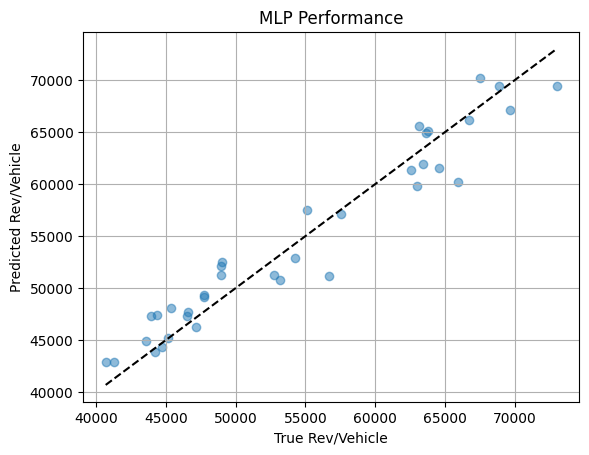

In [14]:
# 9) PLOT RESULTS (last fold)
plt.scatter(y_true,y_pred,alpha=0.5)
mn,mx = y_true.min(), y_true.max()
plt.plot([mn,mx],[mn,mx],'k--')
plt.xlabel('True Rev/Vehicle'); plt.ylabel('Predicted Rev/Vehicle')
plt.title('MLP Performance')
plt.grid(True)
plt.show()

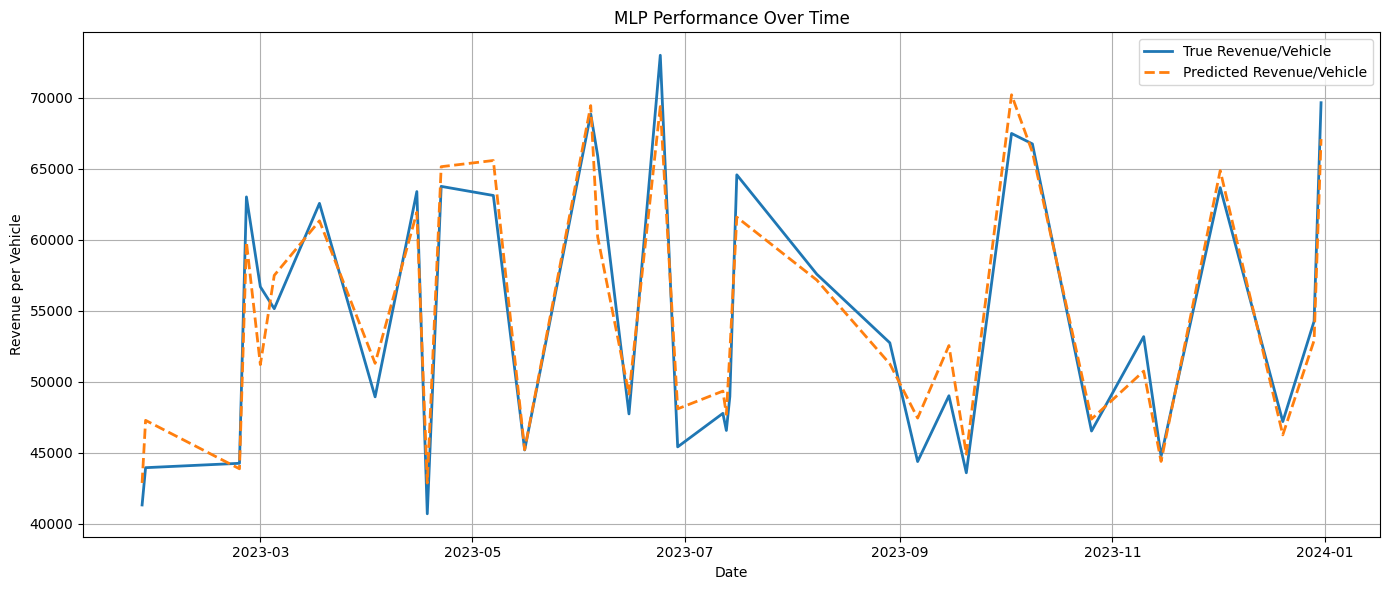

In [15]:
# Prepare the data for plotting
df_plot = pd.DataFrame({
    'date': df_features.iloc[test_idx]['date'],
    'true': y_true.flatten(),
    'predicted': y_pred.flatten()
}).sort_values('date')

# Plot the time series
plt.figure(figsize=(14, 6))
plt.plot(df_plot['date'], df_plot['true'], label='True Revenue/Vehicle', lw=2)
plt.plot(df_plot['date'], df_plot['predicted'], label='Predicted Revenue/Vehicle', ls='--', lw=2)
plt.title('MLP Performance Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue per Vehicle')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:
import torch
print(torch.__version__)
print("CUDA available?", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())

2.7.0+cu118
CUDA available? True
GPU count: 1


In [8]:
df_ml

,date,total_rev,vehicle_count,revenue_per_vehicle,block_id,offday_run,T,RH,P,W,...,rev_ma7,rev_std7,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,hol_True,off_True
0,2023-01-06,4.384192e+07,1079,40631.990778,1,0,0.6,71.9,3.9,2.2,...,40631.990778,0.000000,False,False,False,True,False,False,False,False
1,2023-01-07,6.870620e+07,1260,54528.734034,2,2,1.5,80.9,0.1,2.2,...,47580.362406,9826.481393,False,False,False,False,True,False,False,True
2,2023-01-08,6.838400e+07,1234,55416.535427,2,2,1.3,69.3,0.0,1.7,...,50192.420080,8291.465742,False,False,False,False,False,True,False,True
3,2023-01-09,4.091286e+07,1033,39605.868377,3,0,3.1,60.1,0.0,2.3,...,47545.782154,8593.662704,False,False,False,False,False,False,False,False
4,2023-01-10,4.062744e+07,1016,39987.637697,3,0,1.6,59.9,0.0,1.5,...,46034.153263,8173.945714,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2023-12-27,6.196240e+07,1226,50540.295160,109,0,1.5,76.6,0.0,1.4,...,62132.662173,12577.520560,False,True,False,False,False,False,False,False
356,2023-12-28,6.177597e+07,1202,51394.321922,109,0,1.2,69.5,0.0,1.6,...,62367.759289,12320.208633,False,False,True,False,False,False,False,False
357,2023-12-29,7.428393e+07,1369,54261.450670,109,0,1.3,71.0,0.0,1.7,...,62414.809441,12283.197424,False,False,False,True,False,False,False,False
358,2023-12-30,8.496294e+07,1394,60949.023266,110,2,0.6,92.0,13.1,2.6,...,61459.199398,12067.401285,False,False,False,False,True,False,False,True


In [8]:
import os
import glob
import re
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import weatherReturn
import gc  # Added for explicit garbage collection

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset

# IMPROVED GPU SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Enable cuDNN auto-tuner
torch.backends.cudnn.deterministic = False  # Allow non-deterministic algorithms for speed

def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB / {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print(f"Using device: {device}")
print_gpu_memory()

df_features = pd.read_feather('data/output/df_features.feather')

# columns to one‐hot encode
cat_cols = ['weekday', 'is_holiday', 'is_offday']

# 1) Fit OneHotEncoder (drop first to avoid collinearity)
ohe = OneHotEncoder(drop='first', sparse_output=False)

# 2) Transform the categorical columns
ohe_arr = ohe.fit_transform(df_features[cat_cols])

# 3) Retrieve the new column names
ohe_cols = ohe.get_feature_names_out(cat_cols)

# 4) Build a DataFrame of the encoded columns
df_ohe = pd.DataFrame(ohe_arr, columns=ohe_cols, index=df_features.index)

# 5) Concatenate back with the rest of df_features (dropping original cat_cols)
df_ml = pd.concat([
    df_features.drop(columns=cat_cols),
    df_ohe
], axis=1)

# 6) BUILD X, y (LOG TARGET)
numeric_feats = [
    'vehicle_count',
    'T', 'RH', 'P', 'W', 'S', 'offday_run', 't',
    'weather_score',
    'sin_doy', 'cos_doy',
    'rain_flag', 'windy_flag', 'rain_weekend', 'hot_weekday',
    'sin_month', 'cos_month', 'days_to_hol',
    'rev_lag1', 'rev_lag7', 'rev_ma7', 'rev_std7',
    # 인구 통계 변수
    'male50AgeNmprCnt', 'feml40AgeNmprCnt', 'male80AgeNmprCnt',
    'male20AgeNmprCnt', 'totNmprCnt',    'feml0AgeNmprCnt',
    'male40AgeNmprCnt', 'male90AgeNmprCnt', 'feml10AgeNmprCnt',
    'feml50AgeNmprCnt', 'male10AgeNmprCnt', 'feml100AgeNmprCnt',
    'feml90AgeNmprCnt', 'male30AgeNmprCnt',  'feml20AgeNmprCnt',
    'feml60AgeNmprCnt', 'femlNmprCnt',       'feml30AgeNmprCnt',
    'male0AgeNmprCnt',  'feml80AgeNmprCnt',   'male100AgeNmprCnt',
    'maleNmprCnt',      'male60AgeNmprCnt',   'male70AgeNmprCnt',
    'feml70AgeNmprCnt',
    # 조정 지가
    'adj_land_price',
]
cat_feats = [c for c in df_ml.columns if
             c.startswith(('wd_','hol_','off_','q_','h_'))]
features = numeric_feats + cat_feats

X_raw = df_ml[features].values.astype(np.float32)
y_raw = np.log(df_ml['revenue_per_vehicle'].values.astype(np.float32)).reshape(-1,1)

scaler_X = StandardScaler()
X = scaler_X.fit_transform(X_raw)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y_raw).flatten()

# 7) DATASET & MODEL
class RevenueDataset(Dataset):
    def __init__(self,X,y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).unsqueeze(1)
    def __len__(self): return len(self.y)
    def __getitem__(self,idx): return self.X[idx], self.y[idx]

# convert to torch.Tensor (and ensure y is [N,1])
X_t = torch.from_numpy(X)          # → torch.FloatTensor, shape [N, D]
y_t = torch.from_numpy(y).unsqueeze(1)  # → shape [N, 1]

# now this will work
dataset = TensorDataset(X_t, y_t)

Using device: cuda
GPU Memory: 0.02 GB / 8.59 GB


In [ ]:
from tqdm.auto import tqdm
from torch.amp import autocast as autocast_gpu, GradScaler

torch.backends.cudnn.benchmark = True  # Enable cuDNN auto-tuner
torch.backends.cudnn.deterministic = False  # Allow non-deterministic algorithms for speed

# Function to benchmark the model with different batch sizes to find optimal utilization
def find_optimal_batch_size(model, X_sample, device, start_size=64, max_size=2048):
    """Find the batch size that maximizes GPU utilization"""
    print("Finding optimal batch size for your GPU...")
    
    if not torch.cuda.is_available():
        print("CUDA not available, skipping batch size optimization")
        return 128  # Default
    
    # Convert sample to tensor
    if not isinstance(X_sample, torch.Tensor):
        X_sample = torch.from_numpy(X_sample).float()
    
    # Move model to device
    model = model.to(device)
    model.eval()
    
    best_batch = start_size
    best_util = 0
    
    # Try different batch sizes
    for batch_size in [start_size * (2**i) for i in range(6) if start_size * (2**i) <= max_size]:
        # Warmup
        for _ in range(3):
            with torch.no_grad(), autocast_gpu(device_type='cuda', enabled=True):
                idx = torch.randint(0, len(X_sample) - batch_size, (1,)).item()
                inputs = X_sample[idx:idx+batch_size].to(device)
                _ = model(inputs)
        
        # Measure
        torch.cuda.reset_peak_memory_stats()
        start_util = torch.cuda.utilization()
        
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        
        start.record()
        with torch.no_grad(), autocast_gpu(device_type='cuda', enabled=True):
            for _ in range(10):  # Multiple iterations to get stable measurement
                idx = torch.randint(0, len(X_sample) - batch_size, (1,)).item()
                inputs = X_sample[idx:idx+batch_size].to(device)
                _ = model(inputs)
        end.record()
        
        # Synchronize and get measurements
        torch.cuda.synchronize()
        runtime = start.elapsed_time(end)
        
        # Check utilization
        end_util = torch.cuda.utilization()
        avg_util = (start_util + end_util) / 2
        
        memory_used = torch.cuda.max_memory_allocated() / 1e9
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        
        print(f"Batch size: {batch_size}, GPU Util: {avg_util}%, Memory: {memory_used:.2f}/{total_memory:.2f} GB, Time: {runtime:.2f}ms")
        
        # Update best if utilization is higher
        if avg_util > best_util:
            best_util = avg_util
            best_batch = batch_size
            
        # Stop if we're getting close to memory limits
        if memory_used > 0.9 * total_memory:
            print("Approaching memory limits, stopping search")
            break
    
    print(f"Optimal batch size: {best_batch} with {best_util}% GPU utilization")
    return best_batch
class ComplexMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        # First block - increased width
        self.block1 = nn.Sequential(
            nn.Linear(in_dim, 512),  # Increased from 256
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
        )
        # Second block - increased width
        self.block2 = nn.Sequential(
            nn.Linear(512, 256),  # Increased from 128
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
        )
        # Third block - increased width
        self.block3 = nn.Sequential(
            nn.Linear(256, 128),  # Increased from 64
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
        )
        # Fourth block - increased width
        self.block4 = nn.Sequential(
            nn.Linear(128, 64),  # Increased from 32
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
        )
        # Final prediction head
        self.head = nn.Linear(64, 1)

        # A simple projection for the residual path
        self.residual_proj = nn.Linear(512, 128)  # Adjusted for new dimensions

    def forward(self, x):
        x = self.block1(x)       # → 512
        x2 = self.block2(x)      # → 256
        # add a skip: project x→128 and add to block3 input
        res = self.residual_proj(x)  
        x3 = self.block3(x2)     # → 128
        x3 = x3 + res            # residual sum
        x4 = self.block4(x3)     # → 64
        return self.head(x4)     # → 1

# IMPROVED TRAINING CONFIGURATION
# Significantly larger batch size for better GPU utilization
BATCH_SIZE = 512  # Increased from 128 to push GPU utilization higher
ACCUMULATION_STEPS = 1  # Reduced as we're using larger batches directly
NUM_WORKERS = 4  # Reduced from 4 to prevent CPU bottleneck
PREFETCH_FACTOR = 3  # Increased prefetch factor

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list, r2_list = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    # Clear GPU cache before each fold
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()  # Force garbage collection
    
    train_idx, val_idx = train_test_split(train_idx, test_size=0.1, random_state=42)
    
    # IMPROVED DATALOADERS
    loaders = {
        'train': DataLoader(
            Subset(dataset, train_idx),
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=PREFETCH_FACTOR,
        ),
        'val': DataLoader(
            Subset(dataset, val_idx),
            batch_size=BATCH_SIZE*2,  # Larger batch size for validation
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=PREFETCH_FACTOR,
        ),
        'test': DataLoader(
            Subset(dataset, test_idx),
            batch_size=BATCH_SIZE*2,  # Larger batch size for testing
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=PREFETCH_FACTOR,
        ),
    }
    
    # IMPROVED MODEL INITIALIZATION
    model = ComplexMLP(X.shape[1]).to(device)
    
    # MODIFIED: Skip torch.compile for older GPUs (like GTX 1080)
    if device.type == "cuda":
        props = torch.cuda.get_device_properties(device)
        print(f"CUDA Capability: {props.major}.{props.minor}")
        if props.major >= 7:  # Volta or newer
            print(f"Using torch.compile with default backend")
            model = torch.compile(model)  # default Triton+Inductor
        else:
            print(f"CUDA CC {props.major}.{props.minor} <7.0 → skipping compilation")
            # Skip compilation for older GPUs
    else:
        # Skip compilation for CPU as well
        print("Running on CPU without compilation")

    # IMPROVED OPTIMIZER CONFIGURATION
    opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # Added weight decay
    sched = optim.lr_scheduler.ReduceLROnPlateau(
        opt, 
        factor=0.7,  # More aggressive reduction
        patience=10,  # Reduced patience
        min_lr=1e-6  # Set minimum learning rate
    )
    loss_fn = nn.MSELoss()
    scaler = GradScaler()

    best_val, cnt, patience, best_state = np.inf, 0, 20, None
    
    # Track GPU memory before training
    print_gpu_memory()
    
    # IMPROVED TRAINING LOOP WITH GRADIENT ACCUMULATION
    for epoch in tqdm(range(1000), desc=f'Fold {fold+1} Epochs', leave=False):
        model.train()
        train_losses = []
        
        # Reset gradients at the beginning of each epoch
        opt.zero_grad()
        
        # Training loop with gradient accumulation
        for i, (xb, yb) in enumerate(loaders['train']):
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            
            # Mixed precision forward pass
            with autocast_gpu(device_type='cuda', enabled=(device.type == "cuda")):
                pred = model(xb)
                loss = loss_fn(pred, yb)
                # Normalize loss to account for accumulation
                loss = loss / ACCUMULATION_STEPS
                
            # Mixed precision backward pass
            scaler.scale(loss).backward()
            
            # Only step optimizer after accumulation steps
            if (i + 1) % ACCUMULATION_STEPS == 0:
                scaler.step(opt)
                scaler.update()
                opt.zero_grad()
                
            train_losses.append(loss.item() * ACCUMULATION_STEPS)  # Track original loss value
        
        # Handle any remaining gradients
        if (i + 1) % ACCUMULATION_STEPS != 0:
            scaler.step(opt)
            scaler.update()
            opt.zero_grad()
            
        # Calculate average training loss for the epoch
        avg_train_loss = np.mean(train_losses)
            
        # Validation step
        model.eval()
        val_losses = []
        
        with torch.no_grad():
            for xb, yb in loaders['val']:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                
                with autocast_gpu(device_type='cuda', enabled=(device.type == "cuda")):
                    pred = model(xb)
                    loss = loss_fn(pred, yb)
                    
                val_losses.append(loss.item())
                
        val_loss = np.mean(val_losses)
        
        # Learning rate scheduler step
        sched.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict()
            cnt = 0
        else:
            cnt += 1
            if cnt >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
                
        # Print progress every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}")
            print_gpu_memory()  # Monitor GPU memory
    
    # Load best model for evaluation
    model.load_state_dict(best_state)
    
    # IMPROVED EVALUATION CODE
    preds, trues = [], []
    model.eval()
    
    with torch.no_grad():
        for xb, yb in loaders['test']:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            
            with autocast_gpu(device_type='cuda', enabled=(device.type == "cuda")):
                pred = model(xb)
                
            # Move predictions back to CPU immediately to free GPU memory
            preds.append(pred.cpu().numpy())
            trues.append(yb.cpu().numpy())
            
    # Stack predictions and ground truth
    preds, trues = np.vstack(preds), np.vstack(trues)
    
    # Transform predictions back to original scale
    y_pred_log = scaler_y.inverse_transform(preds)
    y_true_log = scaler_y.inverse_transform(trues)
    
    # Exponentiate to get actual values
    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_true_log)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"Fold {fold+1} — RMSE: {rmse:.2f}, R²: {r2:.3f}")
    rmse_list.append(rmse)
    r2_list.append(r2)
    
    # Free memory
    del model, opt, scaler, loaders
    torch.cuda.empty_cache()
    gc.collect()
    print_gpu_memory()  # Monitor GPU memory

print(f"Avg RMSE: {np.mean(rmse_list):.2f}, Avg R²: {np.mean(r2_list):.3f}")

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000234049885E0>
Traceback (most recent call last):
  File "d:\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "d:\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1622, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "d:\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1558, in _mark_worker_as_unavailable
    assert self._workers_status[worker_id] or (
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


CUDA Capability: 6.1
CUDA CC 6.1 <7.0 → skipping compilation
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:   0%|          | 1/1000 [00:09<2:32:30,  9.16s/it]

Epoch 0: Train Loss = nan, Val Loss = nan
GPU Memory: 0.02 GB / 8.59 GB


KeyboardInterrupt: 

In [36]:
import os
import glob
import re
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import weatherReturn
import gc  # Added for explicit garbage collection

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset

# IMPROVED GPU SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Enable cuDNN auto-tuner
torch.backends.cudnn.deterministic = False  # Allow non-deterministic algorithms for speed

# Track memory usage
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB / {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print(f"Using device: {device}")
print_gpu_memory()

df_features = pd.read_feather('data/output/df_features_seoul.feather')

# Columns to one-hot encode
cat_cols = ['weekday', 'is_holiday', 'is_offday']

# Fit OneHotEncoder (drop first to avoid collinearity)
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Transform the categorical columns
ohe_arr = ohe.fit_transform(df_features[cat_cols])

# Retrieve the new column names
ohe_cols = ohe.get_feature_names_out(cat_cols)

# Build a DataFrame of the encoded columns
df_ohe = pd.DataFrame(ohe_arr, columns=ohe_cols, index=df_features.index)

# Concatenate back with the rest of df_features (dropping original cat_cols)
df_ml = pd.concat([
    df_features.drop(columns=cat_cols),
    df_ohe
], axis=1)

# BUILD X, y (LOG TARGET)
numeric_feats = [
    'vehicle_count',
    'T', 'RH', 'P', 'W', 'S', 'offday_run', 't',
    'weather_score','coupon_count',
    'sin_doy', 'cos_doy',
    'rain_flag', 'windy_flag', 'rain_weekend', 'hot_weekday',
    'sin_month', 'cos_month', 'days_to_hol',
    'rev_lag1', 'rev_lag7', 'rev_ma7', 'rev_std7',
    # # 인구 통계 변수
    'totNmprCnt', 'pct_child', 'pct_teen', 'pct_adult', 'pct_senior',
    #'totNmprCnt','femlNmprCnt','maleNmprCnt',  
    # 조정 지가
    'adj_land_price'
]
cat_feats = [c for c in df_ml.columns if
             c.startswith(('wd_','hol_','off_','q_','h_'))]
features = numeric_feats + cat_feats

X_raw = df_ml[features].values.astype(np.float32)
y_raw = np.log(df_ml['revenue_per_vehicle'].values.astype(np.float32)).reshape(-1,1)

scaler_X = StandardScaler()
X = scaler_X.fit_transform(X_raw)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y_raw).flatten()

# 1) CPU에 FP16 텐서로만 올려 놓기
X_t = torch.from_numpy(X).half()              # CPU float16
y_t = torch.from_numpy(y).half().unsqueeze(1)  # CPU float16

dataset = TensorDataset(X_t, y_t)


Using device: cuda
GPU Memory: 0.03 GB / 8.59 GB


In [31]:
y_t

tensor([[-0.2444],
        [-1.3340],
        [-1.6299],
        ...,
        [ 0.1703],
        [ 0.8486],
        [-1.2402]], dtype=torch.float16)

In [ ]:
from tqdm.auto import tqdm
from torch.amp import autocast as autocast_gpu, GradScaler

torch.backends.cudnn.benchmark = True  # Enable cuDNN auto-tuner
torch.backends.cudnn.deterministic = False  # Allow non-deterministic algorithms for speed


class ComplexMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        # First block - increased width
        self.block1 = nn.Sequential(
            nn.Linear(in_dim, 512),  # Increased from 256
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
        )
        # Second block - increased width
        self.block2 = nn.Sequential(
            nn.Linear(512, 256),  # Increased from 128
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
        )
        # Third block - increased width
        self.block3 = nn.Sequential(
            nn.Linear(256, 128),  # Increased from 64
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
        )
        # Fourth block - increased width
        self.block4 = nn.Sequential(
            nn.Linear(128, 64),  # Increased from 32
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
        )
        # Final prediction head
        self.head = nn.Linear(64, 1)

        # A simple projection for the residual path
        self.residual_proj = nn.Linear(512, 128)  # Adjusted for new dimensions

    def forward(self, x):
        x = self.block1(x)       # → 512
        x2 = self.block2(x)      # → 256
        # add a skip: project x→128 and add to block3 input
        res = self.residual_proj(x)  
        x3 = self.block3(x2)     # → 128
        x3 = x3 + res            # residual sum
        x4 = self.block4(x3)     # → 64
        return self.head(x4)     # → 1

# IMPROVED TRAINING CONFIGURATION
# Significantly larger batch size for better GPU utilization
BATCH_SIZE = 512  # Increased from 128 to push GPU utilization higher
ACCUMULATION_STEPS = 4  # Reduced as we're using larger batches directly
NUM_WORKERS = 8  # Reduced from 4 to prevent CPU bottleneck
PREFETCH_FACTOR = 6  # Increased prefetch factor

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list, r2_list = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    # Clear GPU cache before each fold
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()  # Force garbage collection
    
    train_idx, val_idx = train_test_split(train_idx, test_size=0.1, random_state=42)
    
    # IMPROVED DATALOADERS
    loaders = {
    'train': DataLoader(
        Subset(dataset, train_idx),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,    # multiprocessing OK
        pin_memory=True,           # CPU 텐서이니 pin_memory=True
        persistent_workers=True,
        prefetch_factor=PREFETCH_FACTOR,
    ),
        'val': DataLoader(
            Subset(dataset, val_idx),
            batch_size=BATCH_SIZE*2,  # Larger batch size for validation
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=PREFETCH_FACTOR,
        ),
        'test': DataLoader(
            Subset(dataset, test_idx),
            batch_size=BATCH_SIZE*2,  # Larger batch size for testing
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=PREFETCH_FACTOR,
        ),
    }
    
    # IMPROVED MODEL INITIALIZATION
    model = ComplexMLP(X.shape[1]).to(device)
    
    # MODIFIED: Skip torch.compile for older GPUs (like GTX 1080)
    if device.type == "cuda":
        props = torch.cuda.get_device_properties(device)
        print(f"CUDA Capability: {props.major}.{props.minor}")
        if props.major >= 7:  # Volta or newer
            print(f"Using torch.compile with default backend")
            model = torch.compile(model)  # default Triton+Inductor
        else:
            print(f"CUDA CC {props.major}.{props.minor} <7.0 → skipping compilation")
            # Skip compilation for older GPUs
    else:
        # Skip compilation for CPU as well
        print("Running on CPU without compilation")

    # IMPROVED OPTIMIZER CONFIGURATION
    opt = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)  # Added weight decay
    sched = optim.lr_scheduler.ReduceLROnPlateau(
        opt, 
        factor=0.7,  # More aggressive reduction
        patience=10,  # Reduced patience
        min_lr=1e-6  # Set minimum learning rate
    )
    loss_fn = nn.MSELoss()
    scaler = GradScaler()

    best_val, cnt, patience, best_state = np.inf, 0, 20, None
    
    # Track GPU memory before training
    print_gpu_memory()
    
    # IMPROVED TRAINING LOOP WITH GRADIENT ACCUMULATION
    for epoch in tqdm(range(500), desc=f'Fold {fold+1} Epochs', leave=False):
        model.train()
        train_losses = []
        
        # Reset gradients at the beginning of each epoch
        opt.zero_grad()
        
        # Training loop with gradient accumulation
        for i, (xb, yb) in enumerate(loaders['train']):
            xb = xb.to(device, non_blocking=True)      # 여기서 GPU 로딩
            yb = yb.to(device, non_blocking=True)
            
            # Mixed precision forward pass
            with autocast_gpu(device_type='cuda', enabled=(device.type == "cuda")):
                pred = model(xb)
                loss = loss_fn(pred, yb)
                # Normalize loss to account for accumulation
                loss = loss / ACCUMULATION_STEPS
                
            # Mixed precision backward pass
            scaler.scale(loss).backward()
            
            # Only step optimizer after accumulation steps
            if (i + 1) % ACCUMULATION_STEPS == 0:
                scaler.step(opt)
                scaler.update()
                opt.zero_grad()
                
            train_losses.append(loss.item() * ACCUMULATION_STEPS)  # Track original loss value
        
        # Handle any remaining gradients
        if (i + 1) % ACCUMULATION_STEPS != 0:
            scaler.step(opt)
            scaler.update()
            opt.zero_grad()
            
        # Calculate average training loss for the epoch
        avg_train_loss = np.mean(train_losses)
            
        # Validation step
        model.eval()
        val_losses = []
        
        with torch.no_grad():
            for xb, yb in loaders['val']:
                xb = xb.to(device, non_blocking=True)      # 여기서 GPU 로딩
                yb = yb.to(device, non_blocking=True)
                
                with autocast_gpu(device_type='cuda', enabled=(device.type == "cuda"),dtype=torch.float16):
                    pred = model(xb)
                    loss = loss_fn(pred, yb)
                    
                val_losses.append(loss.item())
                
        val_loss = np.mean(val_losses)
        
        # Learning rate scheduler step
        sched.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict()
            cnt = 0
        else:
            cnt += 1
            #if cnt >= patience:
                #print(f"Early stopping at epoch {epoch}")
                #break
                
        # Print progress every 10 epochs
        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}")
            print_gpu_memory()  # Monitor GPU memory
    
    # Load best model for evaluation
    model.load_state_dict(best_state)
    
    # IMPROVED EVALUATION CODE
    preds, trues = [], []
    model.eval()
    
    with torch.no_grad():
        for xb, yb in loaders['test']:
            xb = xb.to(device, dtype=torch.float16, non_blocking=True)
            yb = yb.to(device, dtype=torch.float16, non_blocking=True)
            
            with autocast_gpu(device_type='cuda', enabled=(device.type == "cuda"),dtype=torch.float16):
                pred = model(xb)
                
            # Move predictions back to CPU immediately to free GPU memory
            preds.append(pred.cpu().numpy())
            trues.append(yb.cpu().numpy())
            
    # Stack predictions and ground truth
    preds, trues = np.vstack(preds), np.vstack(trues)

    # right after stacking preds & trues:
    preds_fp32 = preds.astype(np.float32)
    trues_fp32 = trues.astype(np.float32)


    # Transform predictions back to original scale
    y_pred_log = scaler_y.inverse_transform(preds_fp32)
    y_true_log = scaler_y.inverse_transform(trues_fp32)

    
    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_true_log)

    # Print some statistics to understand the data
    print(f"Predictions - Min: {y_pred.min()}, Max: {y_pred.max()}, Mean: {y_pred.mean()}")
    print(f"True values - Min: {y_true.min()}, Max: {y_true.max()}, Mean: {y_true.mean()}")


    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"Fold {fold+1} — RMSE: {rmse:.2f}, R²: {r2:.3f}")
    rmse_list.append(rmse)
    r2_list.append(r2)
    
    # Free memory
    del model, opt, scaler, loaders
    torch.cuda.empty_cache()
    gc.collect()
    print_gpu_memory()  # Monitor GPU memory

print(f"Avg RMSE: {np.mean(rmse_list):.2f}, Avg R²: {np.mean(r2_list):.3f}")

CUDA Capability: 6.1
CUDA CC 6.1 <7.0 → skipping compilation
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:   0%|          | 1/500 [00:26<3:40:02, 26.46s/it]

Epoch 0: Train Loss = 0.7792, Val Loss = 0.6101
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:   2%|▏         | 11/500 [00:31<06:00,  1.36it/s] 

Epoch 10: Train Loss = 0.5780, Val Loss = 0.5423
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:   4%|▍         | 21/500 [00:36<04:03,  1.97it/s]

Epoch 20: Train Loss = 0.5546, Val Loss = 0.5240
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:   6%|▌         | 31/500 [00:41<03:57,  1.97it/s]

Epoch 30: Train Loss = 0.5417, Val Loss = 0.5234
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:   8%|▊         | 41/500 [00:46<03:58,  1.92it/s]

Epoch 40: Train Loss = 0.5327, Val Loss = 0.5201
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  10%|█         | 51/500 [00:52<03:51,  1.94it/s]

Epoch 50: Train Loss = 0.5257, Val Loss = 0.5244
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  12%|█▏        | 61/500 [00:57<03:44,  1.95it/s]

Epoch 60: Train Loss = 0.5138, Val Loss = 0.5236
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  14%|█▍        | 71/500 [01:02<03:40,  1.95it/s]

Epoch 70: Train Loss = 0.5039, Val Loss = 0.5274
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  16%|█▌        | 81/500 [01:07<03:33,  1.96it/s]

Epoch 80: Train Loss = 0.4951, Val Loss = 0.5274
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  18%|█▊        | 91/500 [01:12<03:30,  1.94it/s]

Epoch 90: Train Loss = 0.4881, Val Loss = 0.5260
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  20%|██        | 101/500 [01:17<03:26,  1.93it/s]

Epoch 100: Train Loss = 0.4835, Val Loss = 0.5329
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  22%|██▏       | 111/500 [01:23<03:21,  1.93it/s]

Epoch 110: Train Loss = 0.4751, Val Loss = 0.5347
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  24%|██▍       | 121/500 [01:28<03:13,  1.96it/s]

Epoch 120: Train Loss = 0.4738, Val Loss = 0.5333
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  26%|██▌       | 131/500 [01:33<03:08,  1.96it/s]

Epoch 130: Train Loss = 0.4740, Val Loss = 0.5324
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  28%|██▊       | 141/500 [01:38<03:04,  1.95it/s]

Epoch 140: Train Loss = 0.4703, Val Loss = 0.5344
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  30%|███       | 151/500 [01:43<02:57,  1.96it/s]

Epoch 150: Train Loss = 0.4700, Val Loss = 0.5344
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  32%|███▏      | 161/500 [01:48<03:00,  1.88it/s]

Epoch 160: Train Loss = 0.4664, Val Loss = 0.5381
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  34%|███▍      | 171/500 [01:54<02:54,  1.89it/s]

Epoch 170: Train Loss = 0.4663, Val Loss = 0.5371
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  36%|███▌      | 181/500 [01:59<02:44,  1.94it/s]

Epoch 180: Train Loss = 0.4648, Val Loss = 0.5326
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  38%|███▊      | 191/500 [02:04<02:39,  1.94it/s]

Epoch 190: Train Loss = 0.4650, Val Loss = 0.5347
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  40%|████      | 201/500 [02:09<02:38,  1.89it/s]

Epoch 200: Train Loss = 0.4664, Val Loss = 0.5350
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  42%|████▏     | 211/500 [02:15<02:28,  1.94it/s]

Epoch 210: Train Loss = 0.4630, Val Loss = 0.5378
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  44%|████▍     | 221/500 [02:20<02:24,  1.93it/s]

Epoch 220: Train Loss = 0.4662, Val Loss = 0.5360
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  46%|████▌     | 231/500 [02:25<02:21,  1.90it/s]

Epoch 230: Train Loss = 0.4602, Val Loss = 0.5375
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  48%|████▊     | 241/500 [02:30<02:12,  1.95it/s]

Epoch 240: Train Loss = 0.4639, Val Loss = 0.5353
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  50%|█████     | 251/500 [02:35<02:06,  1.96it/s]

Epoch 250: Train Loss = 0.4647, Val Loss = 0.5354
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  52%|█████▏    | 261/500 [02:40<02:04,  1.93it/s]

Epoch 260: Train Loss = 0.4643, Val Loss = 0.5365
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  54%|█████▍    | 271/500 [02:46<02:00,  1.90it/s]

Epoch 270: Train Loss = 0.4675, Val Loss = 0.5360
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  56%|█████▌    | 281/500 [02:51<01:58,  1.85it/s]

Epoch 280: Train Loss = 0.4663, Val Loss = 0.5369
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  58%|█████▊    | 291/500 [02:56<01:49,  1.90it/s]

Epoch 290: Train Loss = 0.4665, Val Loss = 0.5378
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  60%|██████    | 301/500 [03:02<01:44,  1.91it/s]

Epoch 300: Train Loss = 0.4631, Val Loss = 0.5388
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  62%|██████▏   | 311/500 [03:07<01:37,  1.93it/s]

Epoch 310: Train Loss = 0.4679, Val Loss = 0.5358
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  64%|██████▍   | 321/500 [03:12<01:33,  1.91it/s]

Epoch 320: Train Loss = 0.4673, Val Loss = 0.5361
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  66%|██████▌   | 331/500 [03:17<01:28,  1.91it/s]

Epoch 330: Train Loss = 0.4675, Val Loss = 0.5364
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  68%|██████▊   | 341/500 [03:23<01:23,  1.90it/s]

Epoch 340: Train Loss = 0.4644, Val Loss = 0.5360
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  70%|███████   | 351/500 [03:28<01:22,  1.81it/s]

Epoch 350: Train Loss = 0.4644, Val Loss = 0.5355
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  72%|███████▏  | 361/500 [03:34<01:15,  1.84it/s]

Epoch 360: Train Loss = 0.4642, Val Loss = 0.5368
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  74%|███████▍  | 371/500 [03:39<01:09,  1.86it/s]

Epoch 370: Train Loss = 0.4640, Val Loss = 0.5369
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  76%|███████▌  | 381/500 [03:44<01:01,  1.93it/s]

Epoch 380: Train Loss = 0.4656, Val Loss = 0.5378
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  78%|███████▊  | 391/500 [03:49<00:56,  1.92it/s]

Epoch 390: Train Loss = 0.4642, Val Loss = 0.5380
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  80%|████████  | 401/500 [03:55<00:51,  1.90it/s]

Epoch 400: Train Loss = 0.4648, Val Loss = 0.5364
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  82%|████████▏ | 411/500 [04:00<00:46,  1.91it/s]

Epoch 410: Train Loss = 0.4650, Val Loss = 0.5375
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  84%|████████▍ | 421/500 [04:05<00:41,  1.91it/s]

Epoch 420: Train Loss = 0.4632, Val Loss = 0.5374
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  86%|████████▌ | 431/500 [04:10<00:35,  1.92it/s]

Epoch 430: Train Loss = 0.4679, Val Loss = 0.5366
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  88%|████████▊ | 441/500 [04:16<00:30,  1.94it/s]

Epoch 440: Train Loss = 0.4645, Val Loss = 0.5374
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  90%|█████████ | 451/500 [04:21<00:25,  1.90it/s]

Epoch 450: Train Loss = 0.4654, Val Loss = 0.5361
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  92%|█████████▏| 461/500 [04:26<00:19,  1.95it/s]

Epoch 460: Train Loss = 0.4655, Val Loss = 0.5356
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  94%|█████████▍| 471/500 [04:31<00:15,  1.92it/s]

Epoch 470: Train Loss = 0.4646, Val Loss = 0.5369
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  96%|█████████▌| 481/500 [04:36<00:09,  1.92it/s]

Epoch 480: Train Loss = 0.4642, Val Loss = 0.5380
GPU Memory: 0.02 GB / 8.59 GB


Fold 1 Epochs:  98%|█████████▊| 491/500 [04:42<00:04,  1.94it/s]

Epoch 490: Train Loss = 0.4646, Val Loss = 0.5365
GPU Memory: 0.02 GB / 8.59 GB


Predictions - Min: 4459.9462890625, Max: 175321.734375, Mean: 48914.37890625
True values - Min: 670.0296020507812, Max: 403599.125, Mean: 52083.73046875
Fold 1 — RMSE: 20701.36, R²: 0.421
GPU Memory: 0.02 GB / 8.59 GB
CUDA Capability: 6.1
CUDA CC 6.1 <7.0 → skipping compilation
GPU Memory: 0.02 GB / 8.59 GB


KeyboardInterrupt: 

In [7]:
from torch.amp import autocast
from tqdm.auto import tqdm

def find_optimal_batch_size_gpu(model, X_gpu, device, start_size=64, max_size=2048):
    # Ensure sample and model are on the same device
    X_gpu = X_gpu.to(device)
    model = model.to(device).eval()
    print("Finding optimal batch size for pure GPU computation...")

    best_batch = start_size
    best_util = 0.0

    start_evt = torch.cuda.Event(enable_timing=True)
    end_evt   = torch.cuda.Event(enable_timing=True)

    max_power = int(torch.log2(torch.tensor(max_size / start_size)).item()) + 1
    batch_sizes = [start_size * (2 ** i) for i in range(max_power) if start_size * (2 ** i) <= max_size]

    for batch_size in batch_sizes:
        for _ in range(5):
            with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
                _ = model(X_gpu[:batch_size])

        torch.cuda.reset_peak_memory_stats()
        util_start = torch.cuda.utilization()

        start_evt.record()
        for _ in range(100):
            with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
                _ = model(X_gpu[:batch_size])
        end_evt.record()
        torch.cuda.synchronize()

        util_end = torch.cuda.utilization()
        avg_util = (util_start + util_end) / 2

        runtime_ms = start_evt.elapsed_time(end_evt)
        mem_used   = torch.cuda.max_memory_allocated() / 1e9
        mem_total  = torch.cuda.get_device_properties(device).total_memory / 1e9

        print(f"Batch {batch_size:4d} | Util: {avg_util:5.1f}% | "
              f"Time: {runtime_ms:6.1f} ms | Mem: {mem_used:.2f}/{mem_total:.2f} GB")

        if avg_util > best_util:
            best_util = avg_util
            best_batch = batch_size

        if mem_used > 0.9 * mem_total:
            print("Reached memory limit, stopping search.")
            break

    print(f"Optimal batch size: {best_batch} (Util {best_util:.1f}%)")
    return best_batch


In [9]:
# 이미 import torch 해두신 상태라면 여기선 생략 가능
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ComplexMLP(X.shape[1]).to(device)

import numpy as np
idx = np.random.choice(len(X), size=min(8192, len(X)), replace=False)
X_sample = torch.from_numpy(X[idx]).to(device, dtype=torch.float16)

best_bs = find_optimal_batch_size_gpu(model, X_sample, device)
print("Recommended batch size →", best_bs)

Finding optimal batch size for pure GPU computation...
Batch   64 | Util:  10.0% | Time:   73.9 ms | Mem: 0.03/8.59 GB
Batch  128 | Util:  18.0% | Time:   80.7 ms | Mem: 0.03/8.59 GB
Batch  256 | Util:  50.5% | Time:   85.1 ms | Mem: 0.03/8.59 GB
Batch  512 | Util:  83.0% | Time:   72.4 ms | Mem: 0.03/8.59 GB
Batch 1024 | Util:  56.5% | Time:   73.2 ms | Mem: 0.03/8.59 GB
Batch 2048 | Util:  30.0% | Time:   69.7 ms | Mem: 0.03/8.59 GB
Optimal batch size: 512 (Util 83.0%)
Recommended batch size → 512


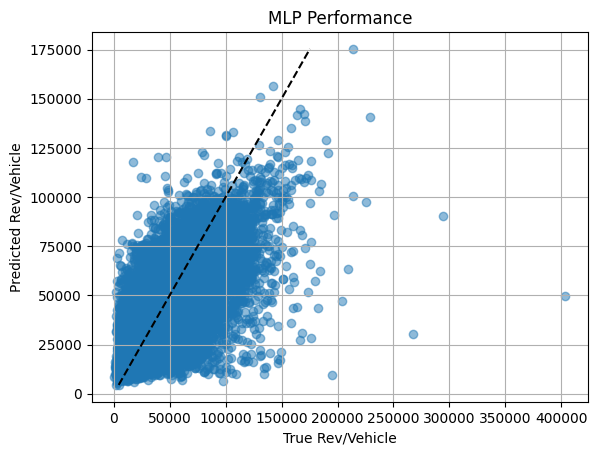

In [39]:
# 9) PLOT RESULTS (last fold)
plt.scatter(y_true,y_pred,alpha=0.5)
mn,mx = y_pred.min(), y_pred.max()
plt.plot([mn,mx],[mn,mx],'k--')
plt.xlabel('True Rev/Vehicle'); plt.ylabel('Predicted Rev/Vehicle')
plt.title('MLP Performance')
plt.grid(True)
plt.show()

In [23]:
import os
import glob
import re
import gc
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
from torch.amp import autocast as autocast_gpu, GradScaler

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from tqdm.auto import tqdm

# 0) GPU & cuDNN 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

def print_gpu_memory():
    if torch.cuda.is_available():
        used = torch.cuda.memory_allocated() / 1e9
        total = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"GPU Memory: {used:.2f} GB / {total:.2f} GB")

print(f"Using device: {device}")
print_gpu_memory()

# 1) 데이터 로드 및 전처리
df_features = pd.read_feather('data/output/df_features.feather')

# 범주형 변수 One-Hot
cat_cols = ['weekday', 'is_holiday', 'is_offday']
ohe = OneHotEncoder(drop='first', sparse_output=False)
ohe_arr = ohe.fit_transform(df_features[cat_cols])
ohe_cols = ohe.get_feature_names_out(cat_cols)
df_ohe = pd.DataFrame(ohe_arr, columns=ohe_cols, index=df_features.index)

df_ml = pd.concat([
    df_features.drop(columns=cat_cols),
    df_ohe
], axis=1)

# 입력·출력 구축 (로그 변환된 타깃)
numeric_feats = [
    'vehicle_count',
    'T','RH','P','W','S','offday_run','t','weather_score',
    'sin_doy','cos_doy','rain_flag','windy_flag','rain_weekend','hot_weekday',
    'sin_month','cos_month','days_to_hol',
    'rev_lag1','rev_lag7','rev_ma7','rev_std7',
    # 인구 통계
    'male50AgeNmprCnt','feml40AgeNmprCnt','male80AgeNmprCnt',
    'male20AgeNmprCnt','totNmprCnt','feml0AgeNmprCnt','male40AgeNmprCnt',
    'male90AgeNmprCnt','feml10AgeNmprCnt','feml50AgeNmprCnt','male10AgeNmprCnt',
    'feml100AgeNmprCnt','feml90AgeNmprCnt','male30AgeNmprCnt','feml20AgeNmprCnt',
    'feml60AgeNmprCnt','femlNmprCnt','feml30AgeNmprCnt','male0AgeNmprCnt',
    'feml80AgeNmprCnt','male100AgeNmprCnt','maleNmprCnt','male60AgeNmprCnt',
    'male70AgeNmprCnt','feml70AgeNmprCnt',
    'adj_land_price'
]
cat_feats = [c for c in df_ml.columns if c.startswith(('wd_','hol_','off_','q_','h_'))]
features = numeric_feats + cat_feats

X_raw = df_ml[features].values.astype(np.float32)
y_raw = np.log(df_ml['revenue_per_vehicle'].values.astype(np.float32)).reshape(-1,1)

# 스케일링
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X_raw)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y_raw).flatten()

# 2) GPU 캐시: FP16으로 변환 후 한 번에 디바이스로 올리기
X_t = torch.from_numpy(X).to(device, non_blocking=True).half()
y_t = torch.from_numpy(y).to(device, non_blocking=True).half().unsqueeze(1)

dataset = TensorDataset(X_t, y_t)

# 3) 모델 정의
class ComplexMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
        )
        self.block2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
        )
        self.block3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
        )
        self.block4 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
        )
        self.head = nn.Linear(64, 1)
        self.residual_proj = nn.Linear(512, 128)

    def forward(self, x):
        x = self.block1(x)
        x2 = self.block2(x)
        res = self.residual_proj(x)
        x3 = self.block3(x2)
        x3 = x3 + res
        x4 = self.block4(x3)
        return self.head(x4)

# 4) 훈련 설정
BATCH_SIZE = 512
ACCUMULATION_STEPS = 3
KFOLDS = 5
EPOCHS = 1000

kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=42)
rmse_list, r2_list = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset), 1):
    # 캐시 비우기
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    # train/val split
    train_idx, val_idx = train_test_split(train_idx, test_size=0.1, random_state=42)

    # 5) DataLoader (num_workers=0, pin_memory=False)
    loaders = {
        'train': DataLoader(
            Subset(dataset, train_idx),
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=0,
            pin_memory=False,
        ),
        'val': DataLoader(
            Subset(dataset, val_idx),
            batch_size=BATCH_SIZE*2,
            shuffle=False,
            num_workers=0,
            pin_memory=False,
        ),
        'test': DataLoader(
            Subset(dataset, test_idx),
            batch_size=BATCH_SIZE*2,
            shuffle=False,
            num_workers=0,
            pin_memory=False,
        ),
    }

    # 모델 & 컴파일
    model = ComplexMLP(X.shape[1]).to(device)
    if device.type == "cuda":
        props = torch.cuda.get_device_properties(device)
        if props.major >= 7:
            model = torch.compile(model)
    print(f"\n--- Fold {fold} ---")
    print_gpu_memory()

    # 옵티마이저, 스케줄러, 스케일러
    opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.7, patience=10, min_lr=1e-6)
    loss_fn = nn.MSELoss()
    scaler = GradScaler()

    best_val, patience_cnt, best_state = np.inf, 0, None

    # 6) 훈련 루프
    for epoch in tqdm(range(EPOCHS), desc=f"Fold {fold} Epochs", leave=False):
        model.train()
        opt.zero_grad()
        train_losses = []

        for i, (xb, yb) in enumerate(loaders['train'], 1):
            with autocast_gpu(str(device),enabled=True):
                pred = model(xb)
                loss = loss_fn(pred, yb) / ACCUMULATION_STEPS
            scaler.scale(loss).backward()

            if i % ACCUMULATION_STEPS == 0:
                scaler.step(opt)
                scaler.update()
                opt.zero_grad()

            train_losses.append(loss.item() * ACCUMULATION_STEPS)

        # 나머지 그래디언트 처리
        if i % ACCUMULATION_STEPS != 0:
            scaler.step(opt)
            scaler.update()
            opt.zero_grad()

        avg_train_loss = np.mean(train_losses)

        # 검증
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in loaders['val']:
                with autocast_gpu(str(device),enabled=True):
                    val_losses.append(loss_fn(model(xb), yb).item())
        val_loss = np.mean(val_losses)

        sched.step(val_loss)

        # 얼리 스톱
        if val_loss < best_val:
            best_val, best_state, patience_cnt = val_loss, model.state_dict(), 0
        else:
            patience_cnt += 1
            if patience_cnt >= 20:
                break

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train={avg_train_loss:.4f}  Val={val_loss:.4f}")
            print_gpu_memory()

    # 베스트 모델 로드
    model.load_state_dict(best_state)

    # 평가
    preds, trues = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in loaders['test']:
            with autocast_gpu(enabled=True):
                p = model(xb)
            preds.append(p.cpu().numpy())
            trues.append(yb.cpu().numpy())

    y_pred = np.exp(scaler_y.inverse_transform(np.vstack(preds)))
    y_true = np.exp(scaler_y.inverse_transform(np.vstack(trues)))

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"Fold {fold}: RMSE={rmse:.2f}, R²={r2:.3f}")
    del model, opt, scaler, loaders
    torch.cuda.empty_cache()
    gc.collect()
    print_gpu_memory()

# 전체 결과
print(f"\nAvg RMSE: {np.mean(rmse_list):.2f}, Avg R²: {np.mean(r2_list):.3f}")


Using device: cuda
GPU Memory: 0.02 GB / 8.59 GB

--- Fold 1 ---
GPU Memory: 0.07 GB / 8.59 GB


KeyboardInterrupt: 